# Clustering

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import scipy.cluster.hierarchy as sc
import kneed

In [2]:
# Function
def func_plot(y,x=None,xlabel=None,ylabel=None,show_mean_x=0,show_mean_y=0,ylim=None,xlim=None):
    fig, ax = plt.subplots(figsize=(20, 10))
    if x is None:
        x = range(0,np.size(y))
    
    ax.scatter(x,y,color='black')
    N = np.size(y)
    if(show_mean_y!=0): plt.plot(x,np.tile(np.mean(y,0),[N,1]),'-.b')
    if(show_mean_x!=0): plt.plot(np.tile(np.mean(x,0),[N,1]),y,'-.b')
        
    if xlabel is not None:plt.xlabel(xlabel)
    if ylabel is not None:plt.ylabel(ylabel)
    
    if ylim is None:ylim=[np.min(y)*1.1,np.max(y)*1.1]
    if xlim is None:xlim=[np.min(x)*1.1,np.max(x)*1.1]
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.show() 

def Euclidean_dist(x1,x2):
    if(np.size(x1)!=np.size(x2)):
        sys.exit("Dimension issue")
    if(len(np.shape(x1))==1):
        euc_dist = np.sqrt(np.sum((x1-x2)**2))
    else:
        euc_dist = np.sqrt(np.sum((x1-x2)**2,axis=1))
        
    return euc_dist

In [3]:
# Data
data = pd.read_excel('pokemon_stat.xlsx')
df = data[['name_poke', 'type1', 'type2', 'hp', 'atk', 'def', 'speatk', 'spedef', 'speed']]
df

,name_poke,type1,type2,hp,atk,def,speatk,spedef,speed
0,skarmory,flying,steel,40,16,18,7,11,17
1,vespiquen,flying,bug,42,14,16,14,16,8
2,farfetch'd,normal,flying,30,15,10,13,11,14
3,dodrio,normal,flying,35,18,12,11,11,18
4,staraptor,normal,flying,50,19,12,12,12,16
...,...,...,...,...,...,...,...,...,...
236,alolan ninetales,ice,fairy,42,12,10,14,16,18
237,galarian weezing,poison,fairy,38,15,19,14,12,11
238,togekiss,flying,fairy,50,11,16,19,18,14
239,altaria,flying,dragon,45,12,15,12,17,14


## Standardized Data

In [4]:
y = np.zeros([241,6])
for i in range(3,9):
    col = df.columns[i]
    y[:,(i-3)] = df[col]

# y contains the statistiques

In [5]:
N = np.size(y,0)  # N = 241
y_std = (y - np.tile(np.mean(y,axis=0),[N,1]))/np.tile(np.std(y,axis=0,ddof=1),[N,1])

## K-Means

In [6]:
def Kmeans_algo(y,nb_K,replic=5):
    N = np.size(y,0)
    if(len(np.shape(y))==1):
        y = np.array(y,ndmin=2)
    
    dimension = np.size(y,1)
    idx_save = np.zeros([N,500])
    for i in range(0,replic):
        
        ### Initialisation of the K-means algorithm
        dist = np.zeros([N,nb_K])
        mu = np.zeros([nb_K,dimension])
        
        if(nb_K>1):
            nb_init = 1000
            idx_start = np.random.randint(0,high=(nb_K-1),size=[N,nb_init])
            std_init = np.std(idx_start,axis=0)
            idx_to_select = np.argsort(std_init)
            idx = idx_start[:,idx_to_select[int(np.floor(i*nb_init/replic) + 1)]]
        else:idx = np.zeros(N)
        
        
        
        ### K-means
        convergence = 0
        idx_save[:,0] = idx
        count = 0
        while(convergence==0):
            for k in range(0,nb_K):
                if(np.sum(idx==k)>0):
                    mu[k,:] = np.mean(y[idx==k,:],axis=0)
                
            idx_prev = idx.copy()
            for k in range(0,nb_K):
                dist[:,k] = Euclidean_dist(y,np.tile(mu[k,:],[N,1]))
                
            idx = np.argmin(dist,axis=1)
            if(np.sum(idx==idx_prev)==N):
                convergence = 1
            
            count = count +1
            idx_save[:,count] = idx
        
        dist_min = 0
        inertia = 0
        for k in range(0,nb_K):
            dist_min = dist_min + np.sum(dist[idx==k,k])
            inertia = inertia + np.sum(dist[idx==k,k]**2)
            
        if(i==0):
            idx_all = idx_save[:,0:(count+1)]
            idx_best = idx
            dist_best = dist_min
            inertia_best = inertia
        elif(dist_min<dist_best):
            idx_all = idx_save[:,0:(count+1)]
            idx_best = idx
            dist_best = dist_min
            inertia_best = inertia
    
    
    return idx_best,idx_all,dist_best,inertia_best

In [7]:
## Aggregate distance per number of clusters.
def dist_per_cluster(y,max_k,replic=5):
    dist = np.zeros([max_k,1])
    for k in np.arange(1,max_k+1):
        output = Kmeans_algo(y,k,replic)
        dist[k-1] = output[2]
    
    return dist

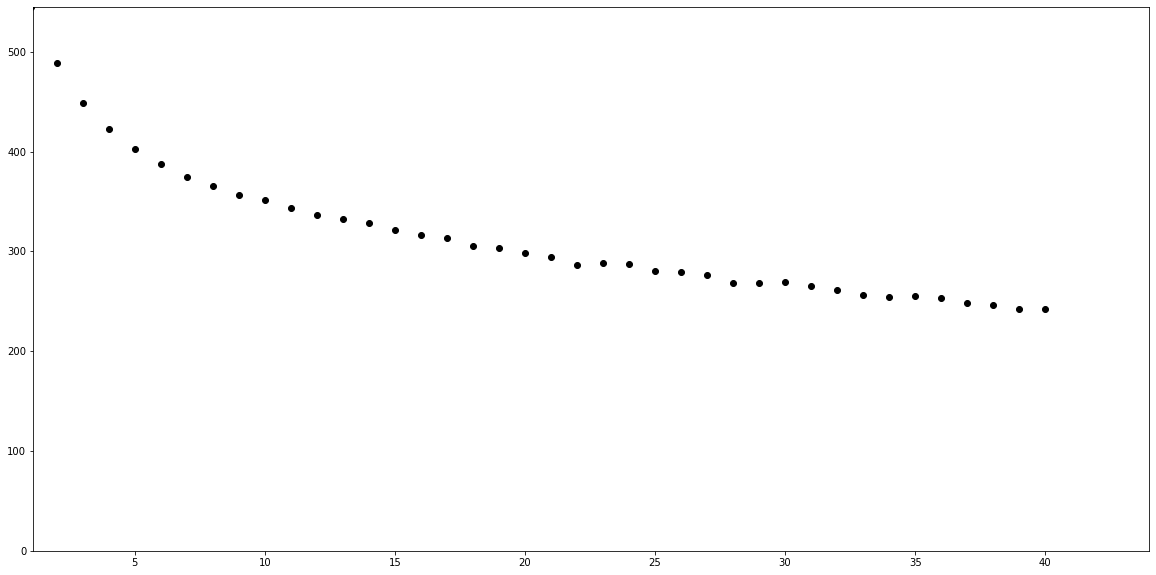

Optimal number of clusters: 11


In [8]:
dist_all = dist_per_cluster(y_std,40,10)

## Aggregate distance w.r.t. the number of clusters
func_plot(dist_all,ylim=[0,np.max(dist_all)],x=np.arange(1,np.size(dist_all)+1))

## To help find the elbow point
kl = kneed.KneeLocator(np.arange(1, np.size(dist_all)+1), dist_all[:,0], curve="convex", direction="decreasing")
print("Optimal number of clusters: " + str(kl.elbow))

In [9]:
a,b,c,d = Kmeans_algo(y_std,11,replic=10)

In [10]:
df['Cluster'] = 0

In [11]:
for i in range(len(a)):
    df['Cluster'][i] = a[i]

C:\Users\33606\AppData\Local\Temp/ipykernel_18300/3410680985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'][i] = a[i]


In [12]:
df.drop(columns=['type1', 'type2','hp','atk','def','speatk','spedef','speed'],inplace = True)

In [13]:
df['Cluster'] = df['Cluster'] + 1

In [14]:
df

,name_poke,Cluster
0,skarmory,2
1,vespiquen,8
2,farfetch'd,5
3,dodrio,3
4,staraptor,3
...,...,...
236,alolan ninetales,1
237,galarian weezing,4
238,togekiss,8
239,altaria,8


In [15]:
df.to_csv('Cluster.csv')